# Ball-and-Stick Neuron Model Tutorial

This tutorial demonstrates how to build and simulate a ball-and-stick neuron model using the NEURON simulator. The model consists of:

- **Soma**: Contains active conductances from the Hay et al. 2011 Layer 5 pyramidal cell model
- **Dendrite**: A single passive dendrite with 64 segments
- **Synapses**: AMPA+NMDA excitatory and GABA-A inhibitory synapses on each dendritic segment

The model simulates the neuron's response to spatiotemporal patterns of excitatory and inhibitory inputs, and outputs detailed voltage traces, spike times, and derived quantities like instantaneous firing rate.


## Installation and Setup

### Installing NEURON

To use this tutorial, you first need to install the NEURON simulator. You can install it via pip:

```bash
pip install neuron
```

### Compiling MOD Files

The model uses custom ion channel and synapse mechanisms defined in `.mod` files located in the `mods/` directory. These files must be compiled before running the simulation.

**Important**: The `nrnivmodl` command must be run from the project root directory (not from within the `notebooks/` subdirectory):

```bash
cd /path/to/tutorial_NEURON_pytorch
nrnivmodl mods/
```

This will create a directory (e.g., `x86_64/` on Linux) containing the compiled mechanisms. The notebook will automatically change to the project root directory when run to ensure these compiled mechanisms can be found.

### Prerequisites

This tutorial also requires:
- `numpy` for numerical operations
- `scipy` for signal processing (spike detection, filtering)
- `matplotlib` for visualization

You can install these with:
```bash
pip install numpy scipy matplotlib
```


## Setup Path and Import Libraries

Since this notebook is located in the `notebooks/` subdirectory, we first need to set up the working directory so NEURON can find the compiled MOD mechanisms in the parent directory. Then we'll import all necessary Python libraries and initialize the NEURON simulator.


In [68]:
# Setup paths - since this notebook is in the notebooks/ subdirectory,
# we need to ensure we can access the compiled MOD files and save models correctly
import os
import sys

# Get the directory containing this notebook
notebook_dir = os.path.dirname(os.path.abspath('__file__')) if '__file__' in dir() else os.getcwd()

# Get the project root directory (parent of notebooks/)
project_root = os.path.dirname(notebook_dir) if 'notebooks' in notebook_dir else notebook_dir

# Change to project root so NEURON can find the compiled mechanisms
os.chdir(project_root)
print(f"Working directory set to: {os.getcwd()}")

Working directory set to: /home/davidbeniaguev/Desktop/code/tutorial_NEURON_pytorch


In [69]:
import pickle
import numpy as np
from scipy import signal
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from neuron import h
h.load_file('stdrun.hoc');

## BallAndStickNeuron Class Definition

The `BallAndStickNeuron` class encapsulates all the functionality needed to create, configure, and simulate a ball-and-stick neuron model. Key features include:

- **Morphology**: Configurable soma and dendrite geometry
- **Biophysics**: Active Hay2011 conductances in the soma, passive dendrite
- **Synapses**: AMPA+NMDA and GABA-A synapses at each dendritic segment
- **Simulation**: recives excitatory and inhibitory weightedspike trains (as matrices) and runs the simulation with and output dictionary containing multiple signals
- **Output**: Multiple output signals including dendritic voltages, somatic voltage, spike trains, near-spike indicators, and instantaneous firing rate


In [70]:
class BallAndStickNeuron:
    def __init__(self, num_segments=64, soma_L_um=25.0, soma_diam_um=25.0, dend_L_um=2048.0, dend_diam_um=1.0,
                 Ra_ohm_cm=150.0, cm_uF_cm2=1.0, Rm_ohm_cm2=20000.0, epas_mV=-85,
                 g_max_AMPA_uS=0.0004, g_max_NMDA_uS=0.0004, gamma_NMDA=0.062, g_max_GABA_A_uS=0.001,
                 multiplicative_rho_factor=1.0, multiplicative_SKE2_factor=1.0, num_samples_per_ms=40,
                 spike_detection_threshold_mV=0.0, soma_voltage_cap_mV=-55.0, dend_voltage_cap_mV=0.0,
                 near_spike_V_diff=5, near_spike_t_diff=10,
                 inst_rate_t_diff=50, inst_rate_smoothing_tau=2.0):
        """
        Initialize a Ball-and-Stick neuron with Hay et al. 2011 soma and passive dendrite, but use NMDA synapses.
        
        Args:
            num_segments (int): Number of dendritic segments
            soma_L_um (float): Soma length in micrometers
            soma_diam_um (float): Soma diameter in micrometers
            dend_L_um (float): Dendrite length in micrometers
            dend_diam_um (float): Dendrite diameter in micrometers
            Ra_ohm_cm (float): Axial resistance in ohm*cm
            cm_uF_cm2 (float): Membrane capacitance in uF/cm^2
            Rm_ohm_cm2 (float): Membrane resistance in ohm*cm^2
            epas_mV (float): Passive reversal potential in mV
            g_max_AMPA_uS (float): Maximum AMPA conductance in microsiemens
            g_max_NMDA_uS (float): Maximum NMDA conductance in microsiemens
            gamma_NMDA (float): NMDA voltage dependence parameter
            g_max_GABA_A_uS (float): Maximum GABA_A conductance in microsiemens
            multiplicative_rho_factor (float): Scaling factor for active conductances
            multiplicative_SKE2_factor (float): Additional scaling factor for SK_E2 conductance
            num_samples_per_ms (int): Number of samples per millisecond (dt calculated as 1/num_samples_per_ms)
            spike_detection_threshold_mV (float): Threshold for spike detection in mV
            soma_voltage_cap_mV (float): Cap value for soma voltage in output (mV)
            dend_voltage_cap_mV (float): Cap value for dendritic voltages in output (mV)
            near_spike_V_diff (float): Voltage difference for near spike detection in mV
            near_spike_t_diff (int): Time delta for near spike detection in ms
            inst_rate_t_diff (int): Time delta for instantaneous rate calculation in ms
            inst_rate_smoothing_tau (float): Smoothing tau for instantaneous rate in ms
        """
        
        # Store all parameters
        self.num_segments = num_segments
        self.soma_L_um = soma_L_um
        self.soma_diam_um = soma_diam_um
        self.dend_L_um = dend_L_um
        self.dend_diam_um = dend_diam_um
        self.Ra_ohm_cm = Ra_ohm_cm
        self.cm_uF_cm2 = cm_uF_cm2
        self.Rm_ohm_cm2 = Rm_ohm_cm2
        self.gpas_S_cm2 = 1 / Rm_ohm_cm2
        self.epas_mV = epas_mV
        
        self.g_max_AMPA_uS = g_max_AMPA_uS
        self.g_max_NMDA_uS = g_max_NMDA_uS
        self.gamma_NMDA = gamma_NMDA
        self.g_max_GABA_A_uS = g_max_GABA_A_uS
        
        self.multiplicative_rho_factor = multiplicative_rho_factor
        self.multiplicative_SKE2_factor = multiplicative_SKE2_factor
        self.num_samples_per_ms = num_samples_per_ms
        self.dt_ms = 1.0 / num_samples_per_ms
        
        self.spike_detection_threshold_mV = spike_detection_threshold_mV
        self.soma_voltage_cap_mV = soma_voltage_cap_mV
        self.dend_voltage_cap_mV = dend_voltage_cap_mV
        self.near_spike_V_diff = near_spike_V_diff
        self.near_spike_t_diff = near_spike_t_diff
        self.inst_rate_t_diff = inst_rate_t_diff
        self.inst_rate_smoothing_tau = inst_rate_smoothing_tau
        
        # Calculate lambda
        self.lambda_um = 100.0 * np.sqrt((dend_diam_um * Rm_ohm_cm2) / (4.0 * Ra_ohm_cm))
        
        # Compute segment fractions and distances
        self.seg_fraction_in_branch = [(i + 0.5) / num_segments for i in range(num_segments)]
        self.seg_distances_um = [frac * dend_L_um for frac in self.seg_fraction_in_branch]
        self.seg_names = [f"seg_{int(round(dist))}_um" for dist in self.seg_distances_um]
        
        # Generate short name
        self.short_name = self._generate_short_name()
        
        # Build the cell morphology
        self.soma, self.dend = self._build_cell()
        
        # Create synapses
        self.all_exc_synapses, self.all_inh_synapses = self._create_synapses()
        
        # Create near-spike and inst-rate filters
        self.causal_filter_near_spike = np.ones(self.near_spike_t_diff)
        self.inst_rate_causal_filter = np.ones(self.inst_rate_t_diff) / self.inst_rate_t_diff
        self.inst_rate_gaussian_size = 1 + 2 * int(4 * self.inst_rate_smoothing_tau)
        self.inst_rate_gaussian_filter = signal.windows.gaussian(self.inst_rate_gaussian_size, std=self.inst_rate_smoothing_tau)
        self.inst_rate_gaussian_filter = self.inst_rate_gaussian_filter / self.inst_rate_gaussian_filter.sum()
        
        # Storage for NetStims and NetCons (to prevent garbage collection)
        self.all_exc_net_stims = []
        self.all_exc_net_cons = []
        self.all_inh_net_stims = []
        self.all_inh_net_cons = []
        
        # Print model info
        self.print_model_info()
    
    def _build_cell(self):
        """Create soma and dendrite sections."""
        # Create soma with Hay 2011 active conductances
        soma = h.Section(name='soma')
        soma.L = self.soma_L_um
        soma.diam = self.soma_diam_um
        soma.Ra = self.Ra_ohm_cm
        soma.cm = self.cm_uF_cm2
        soma.nseg = 1
        
        # Passive properties
        soma.insert('pas')
        soma.e_pas = self.epas_mV
        soma.g_pas = 3e-5
        
        # Active mechanisms - somatic mod files
        soma.insert('Im')
        soma.insert('Ca_LVAst')
        soma.insert('Ca_HVA')
        soma.insert('CaDynamics_E2')
        soma.insert('SK_E2')
        soma.insert('SKv3_1')
        soma.insert('NaTs2_t')
        soma.insert('Ih')
        
        # Active mechanisms - axonal mod files
        soma.insert('K_Tst')
        soma.insert('K_Pst')
        soma.insert('Nap_Et2')
        soma.insert('NaTa_t')
        
        # Reversal potentials
        soma.ek = -85
        soma.ena = 50
        
        # Calcium dynamics
        soma.decay_CaDynamics_E2 = 294.679571
        soma.gamma_CaDynamics_E2 = 0.000509
        
        # Channel conductances
        soma.gImbar_Im = 0.000008 * self.multiplicative_rho_factor
        soma.gCa_LVAstbar_Ca_LVAst = 0.000557 * self.multiplicative_rho_factor
        soma.gCa_HVAbar_Ca_HVA = 0.000644 * self.multiplicative_rho_factor
        soma.gSK_E2bar_SK_E2 = 0.09965 * self.multiplicative_rho_factor * self.multiplicative_SKE2_factor
        soma.gSKv3_1bar_SKv3_1 = 0.338029 * self.multiplicative_rho_factor
        soma.gNaTs2_tbar_NaTs2_t = 0.998912 * self.multiplicative_rho_factor
        soma.gIhbar_Ih = 0.000075 * self.multiplicative_rho_factor
        
        soma.gK_Tstbar_K_Tst = 0.077274 * self.multiplicative_rho_factor
        soma.gK_Pstbar_K_Pst = 0.188851 * self.multiplicative_rho_factor
        soma.gNap_Et2bar_Nap_Et2 = 0.005834 * self.multiplicative_rho_factor
        soma.gNaTa_tbar_NaTa_t = 3.89618 * self.multiplicative_rho_factor
        
        # Create dendrite
        dend = h.Section(name='dend')
        dend.L = self.dend_L_um
        dend.diam = self.dend_diam_um
        dend.cm = self.cm_uF_cm2
        dend.Ra = self.Ra_ohm_cm
        dend.nseg = self.num_segments
        dend.insert('pas')
        for seg in dend:
            seg.pas.g = self.gpas_S_cm2
            seg.pas.e = self.epas_mV
        
        # Connect dendrite to soma
        dend.connect(soma, 1, 0)
        
        return soma, dend
    
    def _create_synapses(self):
        """Create AMPA+NMDA and GABA_A synapses on all dendritic segments."""
        all_exc_synapses = []
        all_inh_synapses = []
        
        for segment_fraction in self.seg_fraction_in_branch:
            segment = self.dend(segment_fraction)
            
            # Create AMPA+NMDA synapse
            exc_synapse = h.Synapse_AMPA_NMDA(segment)
            exc_synapse.tau_r_AMPA = 0.3
            exc_synapse.tau_d_AMPA = 3.0
            exc_synapse.tau_r_NMDA = 2.0
            exc_synapse.tau_d_NMDA = 70.0
            exc_synapse.e_AMPA = 0
            exc_synapse.e_NMDA = 0
            exc_synapse.gmax_AMPA = self.g_max_AMPA_uS
            exc_synapse.gmax_NMDA = self.g_max_NMDA_uS
            exc_synapse.gamma = self.gamma_NMDA
            exc_synapse.mg = 1.0
            all_exc_synapses.append(exc_synapse)
            
            # Create GABA_A synapse
            inh_synapse = h.Synapse_GABA_A(segment)
            inh_synapse.tau_r = 0.2
            inh_synapse.tau_d = 8.0
            inh_synapse.e = -85
            inh_synapse.gmax = self.g_max_GABA_A_uS
            all_inh_synapses.append(inh_synapse)
        
        return all_exc_synapses, all_inh_synapses
    
    def _convert_weighted_spikes_to_events(self, X_weighted_spikes):
        """Convert weighted spike matrix to event dictionaries."""
        num_segments, sim_T_ms = X_weighted_spikes.shape
        
        event_times_in_ms_dict = {}
        event_magnitudes_dict = {}
        for segment_idx in range(num_segments):
            times_idx = np.where(X_weighted_spikes[segment_idx, :] > 0.0)[0]
            event_times_in_ms_dict[segment_idx] = times_idx.astype(float)
            event_magnitudes_dict[segment_idx] = X_weighted_spikes[segment_idx, times_idx]
        
        return event_times_in_ms_dict, event_magnitudes_dict
    
    def _detect_spikes_from_voltage(self, V_soma_hr, dt_ms):
        """Detect spikes from high-resolution soma voltage trace."""
        # Find peaks above threshold
        peaks, _ = signal.find_peaks(V_soma_hr, height=self.spike_detection_threshold_mV)
        return peaks
    
    def _generate_short_name(self):
        """Generate a short descriptive name for the model."""
        short_name_str = f"BallAndStickNeuron_Soma_Hay2011_Dend_Lxd_{int(self.dend_L_um)}um_x_{self.dend_diam_um:.1f}um_{self.num_segments}segs"
        return short_name_str.replace('.', '_')
    
    def simulate(self, X_exc, X_inh, return_hr_soma=False):
        """
        Simulate the ball-and-stick neuron with given excitatory and inhibitory inputs.
        
        Args:
            X_exc (np.ndarray): Excitatory input spikes (num_segments x T) at 1ms resolution
            X_inh (np.ndarray): Inhibitory input spikes (num_segments x T) at 1ms resolution
            return_hr_soma (bool): If True, return high-resolution uncapped soma voltage
            
        Returns:
            output_dict (dict): Dictionary containing dend_voltages, y_soma, y_spike, 
                               y_near_spike, y_inst_rate, and optionally y_soma_hr
        """
        assert X_exc.shape == X_inh.shape, "Excitatory and inhibitory inputs must have same shape"
        assert X_exc.shape[0] == self.num_segments, f"Input dimension must match number of segments ({self.num_segments})"
        
        T = X_exc.shape[1]
        
        # Convert input matrices to event dictionaries
        exc_event_times_dict, exc_event_magnitudes_dict = self._convert_weighted_spikes_to_events(X_exc)
        inh_event_times_dict, inh_event_magnitudes_dict = self._convert_weighted_spikes_to_events(X_inh)
        
        # Clear previous NetStims and NetCons
        self.all_exc_net_stims = []
        self.all_exc_net_cons = []
        self.all_inh_net_stims = []
        self.all_inh_net_cons = []
        
        # Create NetStims and NetCons for excitatory inputs
        for seg_i in range(self.num_segments):
            exc_synapse = self.all_exc_synapses[seg_i]
            for event_time_ms, event_magnitude in zip(exc_event_times_dict[seg_i], 
                                                      exc_event_magnitudes_dict[seg_i]):
                net_stim = h.NetStim()
                net_stim.start = float(event_time_ms)
                net_stim.number = 1
                net_stim.interval = 1e9
                net_stim.noise = 0
                net_con = h.NetCon(net_stim, exc_synapse)
                net_con.delay = 0.0
                net_con.weight[0] = float(event_magnitude)
                self.all_exc_net_stims.append(net_stim)
                self.all_exc_net_cons.append(net_con)
            
            # Create NetStims and NetCons for inhibitory inputs
            inh_synapse = self.all_inh_synapses[seg_i]
            for event_time_ms, event_magnitude in zip(inh_event_times_dict[seg_i], 
                                                      inh_event_magnitudes_dict[seg_i]):
                net_stim = h.NetStim()
                net_stim.start = float(event_time_ms)
                net_stim.number = 1
                net_stim.interval = 1e9
                net_stim.noise = 0
                net_con = h.NetCon(net_stim, inh_synapse)
                net_con.delay = 0.0
                net_con.weight[0] = float(event_magnitude)
                self.all_inh_net_stims.append(net_stim)
                self.all_inh_net_cons.append(net_con)
        
        # Setup recording vectors
        t_vec_rec = h.Vector().record(h._ref_t)
        V_soma_rec = h.Vector().record(self.soma(0.5)._ref_v)
        
        V_dend_rec = []
        for i in range(self.num_segments):
            V_dend_vec = h.Vector().record(self.dend(self.seg_fraction_in_branch[i])._ref_v)
            V_dend_rec.append(V_dend_vec)
        
        # Run simulation
        h.dt = self.dt_ms
        h.tstop = T
        h.finitialize(self.epas_mV)
        h.continuerun(T)
        
        # Extract high-resolution traces
        t_HR = np.array(t_vec_rec)
        V_soma_HR = np.array(V_soma_rec)
        V_dend_matrix_HR = np.array([np.array(V_dend_vec) for V_dend_vec in V_dend_rec])
        
        # Detect spikes from HR soma voltage
        spike_peaks_hr = self._detect_spikes_from_voltage(V_soma_HR, self.dt_ms)
        
        # Downsample to 1ms resolution
        downsample_factor = self.num_samples_per_ms
        V_soma_LR = V_soma_HR[::downsample_factor][:T]
        V_dend_matrix_LR = V_dend_matrix_HR[:, ::downsample_factor][:, :T]
        
        # Convert spike peaks to 1ms binary array
        y_spike = np.zeros(T)
        spike_times_1ms = (spike_peaks_hr / downsample_factor).astype(int)
        spike_times_1ms = spike_times_1ms[spike_times_1ms < T]
        y_spike[spike_times_1ms] = 1
        
        # Cap voltages
        y_soma = np.minimum(V_soma_LR, self.soma_voltage_cap_mV)
        dend_voltages = np.minimum(V_dend_matrix_LR, self.dend_voltage_cap_mV)
        
        # Calculate near spike
        y_near_spike_spike = signal.convolve(y_spike, self.causal_filter_near_spike, 
                                            mode='full')[:-self.near_spike_t_diff+1] > 0
        y_near_spike_soma = V_soma_LR > (self.soma_voltage_cap_mV - self.near_spike_V_diff)
        y_near_spike = np.logical_or(y_near_spike_spike, y_near_spike_soma)
        
        # Calculate instantaneous rate
        y_inst_rate = signal.convolve(y_spike, self.inst_rate_causal_filter, 
                                     mode='full')[:-self.inst_rate_t_diff+1]
        y_inst_rate = signal.convolve(y_inst_rate, self.inst_rate_gaussian_filter, mode='same')
        
        # Build output dictionary
        output_dict = {
            'branch_voltages': dend_voltages.astype(np.float16),
            'y_soma': y_soma.astype(np.float32),
            'y_spike': y_spike.astype(bool),
            'y_near_spike': y_near_spike.astype(bool),
            'y_inst_rate': y_inst_rate.astype(np.float32),
        }
        
        if return_hr_soma:
            output_dict['y_soma_HR'] = V_soma_HR.astype(np.float32)
        
        return output_dict
    
    def print_model_info(self):
        """Print model information."""
        print('----------------------------------------------')
        print(f"Ball-and-Stick Neuron initialized")
        print(f"Short name: {self.short_name}")
        print('----------------------------------------------')
        print(f'  Morphology:')
        print(f'    Number of segments: {self.num_segments}')
        print(f'    Soma: L={self.soma_L_um} um, diam={self.soma_diam_um} um')
        print(f'    Dendrite: L={self.dend_L_um} um, diam={self.dend_diam_um} um')
        print(f'    Lambda: {self.lambda_um:.2f} um')
        print(f'    Branch length in units of lambda: {self.dend_L_um / self.lambda_um:.2f}')
        print(f'    Each segment length in units of lambda: {self.dend_L_um / self.num_segments / self.lambda_um:.4f}')
        print(f'  Biophysics:')
        print(f'    Ra: {self.Ra_ohm_cm} ohm*cm')
        print(f'    cm: {self.cm_uF_cm2} uF/cm^2')
        print(f'    Rm: {self.Rm_ohm_cm2} ohm*cm^2')
        print(f'    epas: {self.epas_mV} mV')
        print(f'  Synapses:')
        print(f'    g_max_AMPA: {self.g_max_AMPA_uS} uS')
        print(f'    g_max_NMDA: {self.g_max_NMDA_uS} uS')
        print(f'    gamma_NMDA: {self.gamma_NMDA}')
        print(f'    g_max_GABA_A: {self.g_max_GABA_A_uS} uS')
        print(f'  Active conductances:')
        print(f'    multiplicative_rho_factor: {self.multiplicative_rho_factor}')
        print(f'    multiplicative_SKE2_factor: {self.multiplicative_SKE2_factor}')
        print(f'  Simulation:')
        print(f'    samples per ms: {self.num_samples_per_ms}')
        print(f'    dt: {self.dt_ms} ms (calculated as 1/samples_per_ms)')
        print(f'  Spike detection:')
        print(f'    threshold: {self.spike_detection_threshold_mV} mV')
        print(f'  Output voltage caps:')
        print(f'    soma_voltage_cap: {self.soma_voltage_cap_mV} mV')
        print(f'    dend_voltage_cap: {self.dend_voltage_cap_mV} mV')
        print(f'  Near-spike parameters:')
        print(f'    near_spike_V_diff: {self.near_spike_V_diff} mV')
        print(f'    near_spike_t_diff: {self.near_spike_t_diff} ms')
        print(f'  Instantaneous rate parameters:')
        print(f'    inst_rate_t_diff: {self.inst_rate_t_diff} ms')
        print(f'    inst_rate_smoothing_tau: {self.inst_rate_smoothing_tau} ms')
        print('----------------------------------------------')
    
    def save(self, file_folder, name_prefix='ball_and_stick_neuron'):
        """Save the model parameters to a pickle file."""
        os.makedirs(file_folder, exist_ok=True)
        
        # Create parameter dictionary
        params = {
            'num_segments': self.num_segments,
            'soma_L_um': self.soma_L_um,
            'soma_diam_um': self.soma_diam_um,
            'dend_L_um': self.dend_L_um,
            'dend_diam_um': self.dend_diam_um,
            'Ra_ohm_cm': self.Ra_ohm_cm,
            'cm_uF_cm2': self.cm_uF_cm2,
            'Rm_ohm_cm2': self.Rm_ohm_cm2,
            'epas_mV': self.epas_mV,
            'g_max_AMPA_uS': self.g_max_AMPA_uS,
            'g_max_NMDA_uS': self.g_max_NMDA_uS,
            'gamma_NMDA': self.gamma_NMDA,
            'g_max_GABA_A_uS': self.g_max_GABA_A_uS,
            'multiplicative_rho_factor': self.multiplicative_rho_factor,
            'multiplicative_SKE2_factor': self.multiplicative_SKE2_factor,
            'num_samples_per_ms': self.num_samples_per_ms,
            'spike_detection_threshold_mV': self.spike_detection_threshold_mV,
            'soma_voltage_cap_mV': self.soma_voltage_cap_mV,
            'dend_voltage_cap_mV': self.dend_voltage_cap_mV,
            'near_spike_V_diff': self.near_spike_V_diff,
            'near_spike_t_diff': self.near_spike_t_diff,
            'inst_rate_t_diff': self.inst_rate_t_diff,
            'inst_rate_smoothing_tau': self.inst_rate_smoothing_tau,
        }
        
        # Generate filename with timestamp
        current_date = datetime.now().strftime('%Y_%m_%d_%Hh%Mm')
        filename = f"{name_prefix}_{self.short_name}__{current_date}.pkl"
        filepath = os.path.join(file_folder, filename)
        
        # Save parameters
        with open(filepath, 'wb') as f:
            pickle.dump(params, f)
        
        print(f"Model saved to: {filepath}")
        return filepath
    
    @classmethod
    def load(cls, filepath):
        """Load a model from a pickle file."""
        with open(filepath, 'rb') as f:
            params = pickle.load(f)
        
        # Create new instance with loaded parameters
        return cls(**params)


## Demo: Configure Model Parameters

Now we'll configure all the parameters for our demonstration. We can choose between different synapse types:

- **AMPA only**: Fast excitatory transmission, no voltage dependence
- **NMDA (rodent)**: Combined AMPA+NMDA with 1:1 ratio and moderate voltage dependence
- **NMDA (human)**: Combined AMPA+NMDA with 1:2 ratio and steeper voltage dependence

The SK_E2 channel controls a long-lasting calcium-activated potassium current that produces extended hyperpolarization after spikes. We'll disable it here to see more spiking activity.


In [71]:
# some high-level parameters
# exc_synapse_type = 'AMPA'
# exc_synapse_type = 'NMDA (rodent)'
exc_synapse_type = 'NMDA (human)' # larger NMDA:AMPA ratio, steeper NMDA voltage dependence 

# SKE2 channel controls a very long hyperpolarizing current after a spike
disable_SKE2_channel = True
# disable_SKE2_channel = False

# Define all parameters
num_segments = 64
soma_L_um = 25.0
soma_diam_um = 25.0

# large dendrite (~3.5 times lambda)
dend_L_um = 2048.0
dend_diam_um = 1.0

# small dendrite (~0.1 times lambda) - basically a point neuron
# dend_L_um = 128.0
# dend_diam_um = 4.0

# passive biophysics
Ra_ohm_cm = 150.0
cm_uF_cm2 = 1.0
Rm_ohm_cm2 = 20000.0
epas_mV = -85

# synapses
if exc_synapse_type == 'AMPA':
    g_max_AMPA_uS = 0.0004
    g_max_NMDA_uS = 0.0000 # no NMDA conductance
    gamma_NMDA = 0.062
elif exc_synapse_type == 'NMDA (rodent)':
    g_max_AMPA_uS = 0.0004
    g_max_NMDA_uS = 0.0004
    gamma_NMDA = 0.062
elif exc_synapse_type == 'NMDA (human)':
    g_max_AMPA_uS = 0.0004
    g_max_NMDA_uS = 0.0008 # larger NMDA:AMPA ratio
    gamma_NMDA = 0.08      # steeper NMDA voltage dependence
g_max_GABA_A_uS = 0.001

# active conductances multipliers
multiplicative_rho_factor = 1.0
if disable_SKE2_channel:
    multiplicative_SKE2_factor = 0.0
else:
    multiplicative_SKE2_factor = 1.0

# simulation parameters
num_samples_per_ms = 40
spike_detection_threshold_mV = 0.0
soma_voltage_cap_mV = -62.0
dend_voltage_cap_mV = 0.0
near_spike_V_diff = 5
near_spike_t_diff = 10
inst_rate_t_diff = 50
inst_rate_smoothing_tau = 2.0


## Create the Neuron Instance

Now we instantiate the ball-and-stick neuron with all the parameters we've configured. This will create the soma and dendrite, insert all ion channels, create synapses, and print a detailed summary of the model configuration.


In [72]:
# Create neuron with defined parameters
ball_and_stick_neuron = BallAndStickNeuron(
    num_segments=num_segments,
    soma_L_um=soma_L_um,
    soma_diam_um=soma_diam_um,
    dend_L_um=dend_L_um,
    dend_diam_um=dend_diam_um,
    Ra_ohm_cm=Ra_ohm_cm,
    cm_uF_cm2=cm_uF_cm2,
    Rm_ohm_cm2=Rm_ohm_cm2,
    epas_mV=epas_mV,
    g_max_AMPA_uS=g_max_AMPA_uS,
    g_max_NMDA_uS=g_max_NMDA_uS,
    gamma_NMDA=gamma_NMDA,
    g_max_GABA_A_uS=g_max_GABA_A_uS,
    multiplicative_rho_factor=multiplicative_rho_factor,
    multiplicative_SKE2_factor=multiplicative_SKE2_factor,
    num_samples_per_ms=num_samples_per_ms,
    spike_detection_threshold_mV=spike_detection_threshold_mV,
    soma_voltage_cap_mV=soma_voltage_cap_mV,
    dend_voltage_cap_mV=dend_voltage_cap_mV,
    near_spike_V_diff=near_spike_V_diff,
    near_spike_t_diff=near_spike_t_diff,
    inst_rate_t_diff=inst_rate_t_diff,
    inst_rate_smoothing_tau=inst_rate_smoothing_tau,
)


----------------------------------------------
Ball-and-Stick Neuron initialized
Short name: BallAndStickNeuron_Soma_Hay2011_Dend_Lxd_2048um_x_1_0um_64segs
----------------------------------------------
  Morphology:
    Number of segments: 64
    Soma: L=25.0 um, diam=25.0 um
    Dendrite: L=2048.0 um, diam=1.0 um
    Lambda: 577.35 um
    Branch length in units of lambda: 3.55
    Each segment length in units of lambda: 0.0554
  Biophysics:
    Ra: 150.0 ohm*cm
    cm: 1.0 uF/cm^2
    Rm: 20000.0 ohm*cm^2
    epas: -85 mV
  Synapses:
    g_max_AMPA: 0.0004 uS
    g_max_NMDA: 0.0008 uS
    gamma_NMDA: 0.08
    g_max_GABA_A: 0.001 uS
  Active conductances:
    multiplicative_rho_factor: 1.0
    multiplicative_SKE2_factor: 0.0
  Simulation:
    samples per ms: 40
    dt: 0.025 ms (calculated as 1/samples_per_ms)
  Spike detection:
    threshold: 0.0 mV
  Output voltage caps:
    soma_voltage_cap: -62.0 mV
    dend_voltage_cap: 0.0 mV
  Near-spike parameters:
    near_spike_V_diff: 5 mV


## Generate Input Patterns

We'll create spatiotemporal input patterns for the neuron. The inputs consist of:

1. **Random sparse background**: Very sparse random excitatory and inhibitory events across all segments
2. **Structured patterns**: A sequence of strong excitatory inputs that propagate from proximal to distal dendrite and back

Each input event has a magnitude (weight) that scales the synaptic conductance. This weighted-spike representation allows us to simulate both the timing and strength of synaptic inputs.


In [73]:
# Simulation parameters
sim_T_ms = 1024

# Generate random sparse input
exc_max_magnitude_factor = 5
# exc_sparsity_level = 0.998
exc_sparsity_level = 0.99999999
inh_max_magnitude_factor = 5
# inh_sparsity_level = 0.999
inh_sparsity_level = 0.99999999

X_exc_weighted_spikes = np.random.rand(ball_and_stick_neuron.num_segments, sim_T_ms) * exc_max_magnitude_factor
X_exc_weighted_spikes[np.random.rand(ball_and_stick_neuron.num_segments, sim_T_ms) < exc_sparsity_level] = 0.0

X_inh_weighted_spikes = np.random.rand(ball_and_stick_neuron.num_segments, sim_T_ms) * inh_max_magnitude_factor
X_inh_weighted_spikes[np.random.rand(ball_and_stick_neuron.num_segments, sim_T_ms) < inh_sparsity_level] = 0.0

# Add patterned excitatory spikes from proximal to distal and back
patterned_magnitude = 9.0
X_exc_weighted_spikes[int(0.05 * ball_and_stick_neuron.num_segments), int(0.1 * sim_T_ms)] = patterned_magnitude
X_exc_weighted_spikes[int(0.25 * ball_and_stick_neuron.num_segments), int(0.2 * sim_T_ms)] = patterned_magnitude
X_exc_weighted_spikes[int(0.50 * ball_and_stick_neuron.num_segments), int(0.3 * sim_T_ms)] = patterned_magnitude
X_exc_weighted_spikes[int(0.75 * ball_and_stick_neuron.num_segments), int(0.4 * sim_T_ms)] = patterned_magnitude
X_exc_weighted_spikes[int(0.95 * ball_and_stick_neuron.num_segments), int(0.5 * sim_T_ms)] = patterned_magnitude
X_exc_weighted_spikes[int(0.75 * ball_and_stick_neuron.num_segments), int(0.6 * sim_T_ms)] = patterned_magnitude
X_exc_weighted_spikes[int(0.50 * ball_and_stick_neuron.num_segments), int(0.7 * sim_T_ms)] = patterned_magnitude
X_exc_weighted_spikes[int(0.25 * ball_and_stick_neuron.num_segments), int(0.8 * sim_T_ms)] = patterned_magnitude
X_exc_weighted_spikes[int(0.05 * ball_and_stick_neuron.num_segments), int(0.9 * sim_T_ms)] = patterned_magnitude


## Run the Simulation

We now run the NEURON simulation with our input patterns. The simulation runs at high temporal resolution (40 samples per millisecond) internally, then outputs are downsampled to 1ms resolution. We also request the high-resolution soma voltage trace for detailed visualization.


In [74]:
# Run simulation
print('----------------------------------------------')
print('Running simulation...')
simulation_output = ball_and_stick_neuron.simulate(X_exc_weighted_spikes, X_inh_weighted_spikes, return_hr_soma=True)
print('Simulation complete!')
print('----------------------------------------------')


----------------------------------------------
Running simulation...
Simulation complete!
----------------------------------------------


## Extract and Display Results

The simulation returns a dictionary containing multiple output signals:

- `branch_voltages`: Dendritic voltage at each segment (64 x T)
- `y_soma`: Soma voltage capped at specified level (1 x T)
- `y_spike`: Binary spike train (1 x T)
- `y_near_spike`: Binary indicator for near-spike periods (1 x T)
- `y_inst_rate`: Smoothed instantaneous firing rate (1 x T)
- `y_soma_HR`: High-resolution uncapped soma voltage

Let's extract these outputs and print some statistics.


In [75]:
# Extract outputs
branch_voltages = simulation_output['branch_voltages']
y_soma = simulation_output['y_soma']
y_spike = simulation_output['y_spike']
y_near_spike = simulation_output['y_near_spike']
y_inst_rate = simulation_output['y_inst_rate']
y_soma_HR = simulation_output['y_soma_HR']

# Print output statistics
print('Output shapes:')
print(f'  branch_voltages: {branch_voltages.shape}')
print(f'  y_soma: {y_soma.shape}')
print(f'  y_spike: {y_spike.shape}')
print(f'  y_near_spike: {y_near_spike.shape}')
print(f'  y_inst_rate: {y_inst_rate.shape}')
print(f'  y_soma_HR: {y_soma_HR.shape}')
print('----------------------------------------------')
print(f'Number of spikes: {y_spike.sum()}')
print(f'Average firing rate: {y_spike.mean() * 1000:.2f} Hz')
print('----------------------------------------------')


Output shapes:
  branch_voltages: (64, 1024)
  y_soma: (1024,)
  y_spike: (1024,)
  y_near_spike: (1024,)
  y_inst_rate: (1024,)
  y_soma_HR: (40961,)
----------------------------------------------
Number of spikes: 0
Average firing rate: 0.00 Hz
----------------------------------------------


## Visualization: Main Results Figure

We'll create a comprehensive multi-panel figure showing:

1. **Input spikes**: Spatiotemporal map of excitatory (green) and inhibitory (red) inputs
2. **Dendritic voltages**: Heatmap of voltage along the dendrite with input overlay
3. **Somatic voltage**: Time course of soma voltage with detected spikes marked
4. **Near-spike indicator**: Binary signal indicating proximity to spikes
5. **Instantaneous firing rate**: Smoothed estimate of firing rate over time


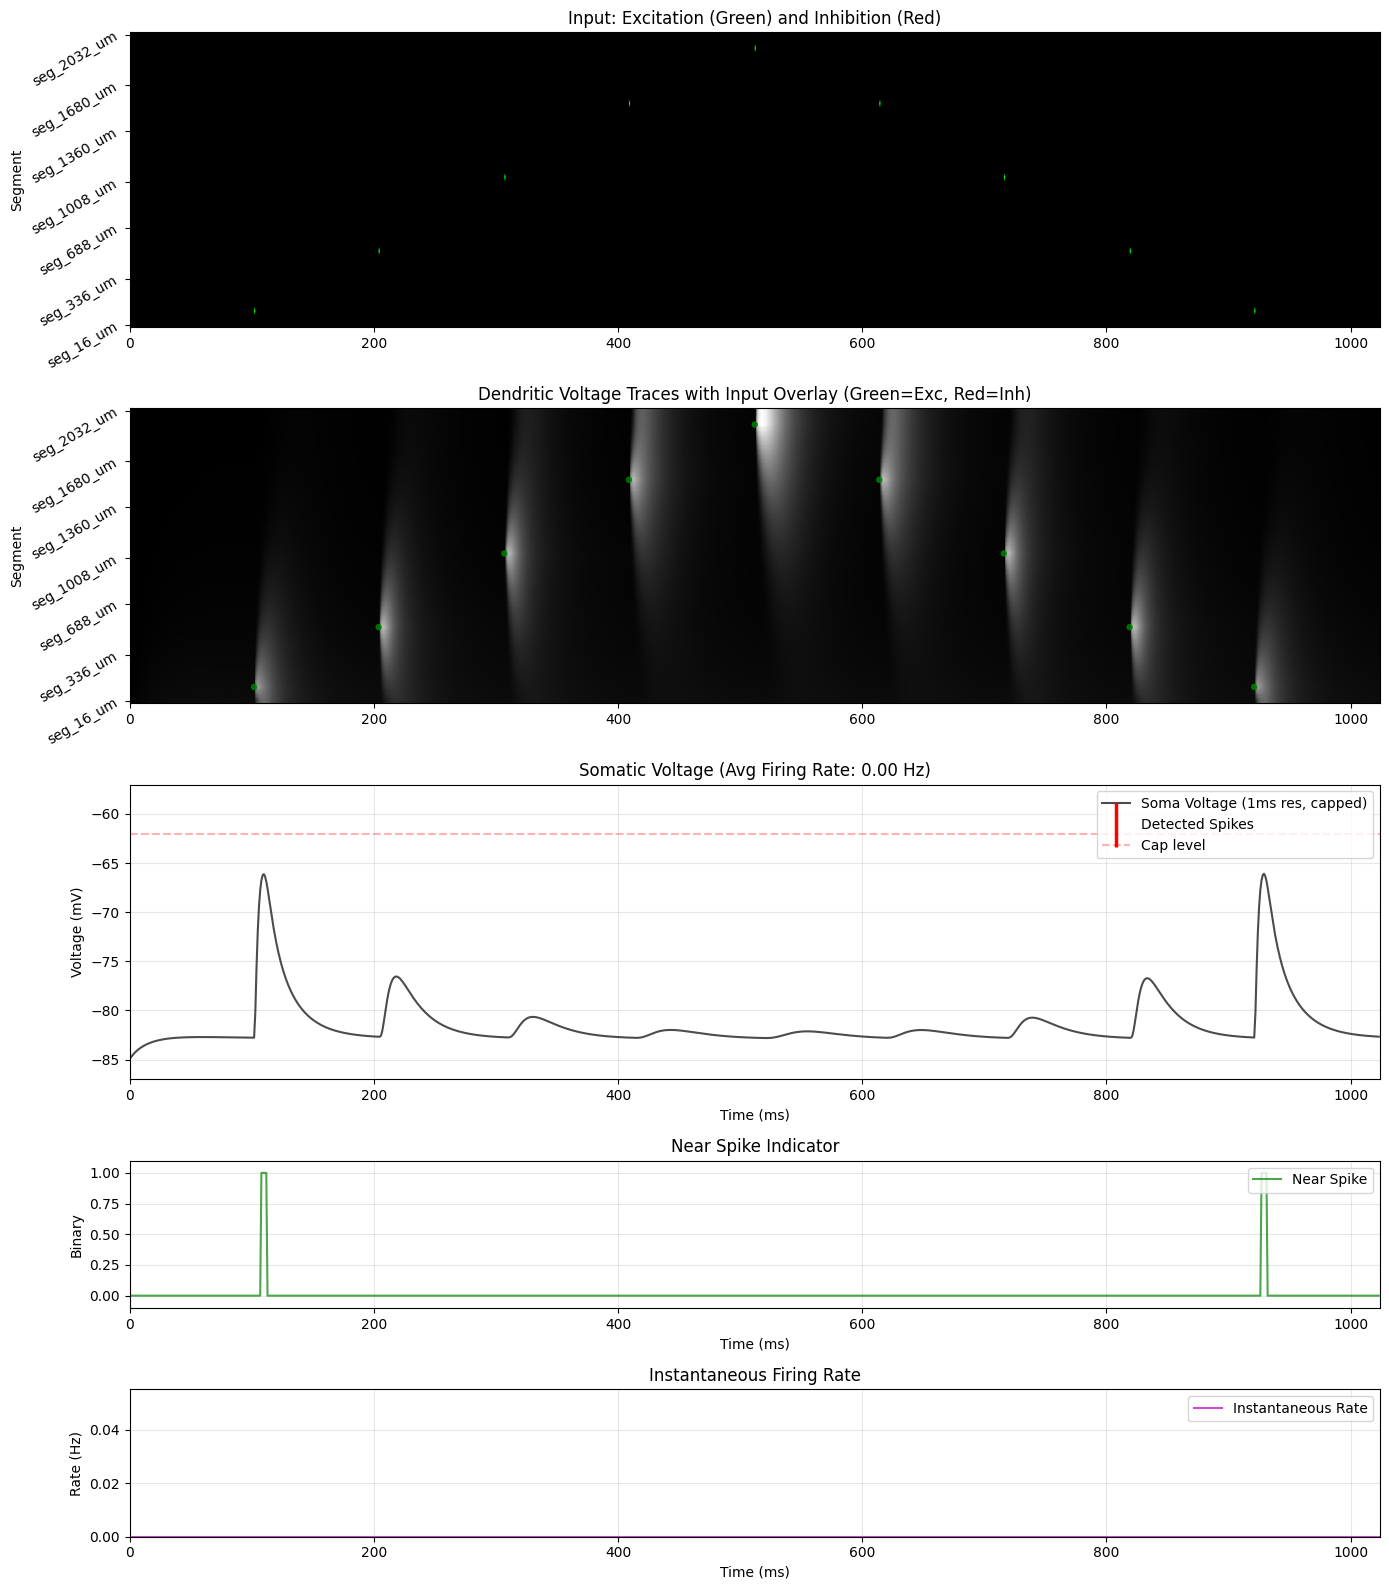

In [76]:
# Plot results
if X_exc_weighted_spikes.max() != 0:
    X_exc_weighted_spikes_normalized = X_exc_weighted_spikes / X_exc_weighted_spikes.max()
else:
    X_exc_weighted_spikes_normalized = X_exc_weighted_spikes

if X_inh_weighted_spikes.max() != 0:
    X_inh_weighted_spikes_normalized = X_inh_weighted_spikes / X_inh_weighted_spikes.max()
else:
    X_inh_weighted_spikes_normalized = X_inh_weighted_spikes

# Create RGB image of input
X_weighted_spikes_as_RGB = np.zeros((ball_and_stick_neuron.num_segments, sim_T_ms, 3))
X_weighted_spikes_as_RGB[:, :, 1] = X_exc_weighted_spikes_normalized  # Green for excitation
X_weighted_spikes_as_RGB[:, :, 0] = X_inh_weighted_spikes_normalized  # Red for inhibition

# Get spike coordinates for overlay
scatter_scale_factor = 1.5
exc_segment_coords, exc_time_coords = np.where(X_exc_weighted_spikes > 0)
exc_magnitudes = scatter_scale_factor * X_exc_weighted_spikes[exc_segment_coords, exc_time_coords]
inh_segment_coords, inh_time_coords = np.where(X_inh_weighted_spikes > 0)
inh_magnitudes = scatter_scale_factor * X_inh_weighted_spikes[inh_segment_coords, inh_time_coords]

# Flip coordinates for display
exc_segment_coords_flipped = (ball_and_stick_neuron.num_segments - 1) - exc_segment_coords
inh_segment_coords_flipped = (ball_and_stick_neuron.num_segments - 1) - inh_segment_coords

# Select evenly-spaced segments for y-axis ticks
num_y_ticks = 7
tick_indices = np.linspace(0, ball_and_stick_neuron.num_segments - 1, num_y_ticks, dtype=int)
tick_labels = [ball_and_stick_neuron.seg_names[i] for i in tick_indices]
tick_positions = [(ball_and_stick_neuron.num_segments - 1 - i) for i in tick_indices]

# Create main figure
plt.figure(figsize=(14, 16))
gs = gridspec.GridSpec(5, 1, height_ratios=[2, 2, 2, 1, 1])
plt.subplots_adjust(hspace=0.4)

# Plot 1: Input spikes
ax1 = plt.subplot(gs[0])
ax1.imshow(np.flipud(X_weighted_spikes_as_RGB), aspect='auto')
ax1.set_ylabel('Segment')
ax1.set_title('Input: Excitation (Green) and Inhibition (Red)')
ax1.set_yticks(tick_positions)
ax1.set_yticklabels(tick_labels, rotation=30)
ax1.set_xlim(0, sim_T_ms)

# Plot 2: Dendritic voltages with input overlay
ax2 = plt.subplot(gs[1])
ax2.imshow(np.flipud(branch_voltages), aspect='auto', cmap='gray')
ax2.scatter(exc_time_coords, exc_segment_coords_flipped, s=exc_magnitudes, c='green', alpha=0.8)
ax2.scatter(inh_time_coords, inh_segment_coords_flipped, s=inh_magnitudes, c='red', alpha=0.5)
ax2.set_ylabel('Segment')
ax2.set_title('Dendritic Voltage Traces with Input Overlay (Green=Exc, Red=Inh)')
ax2.set_yticks(tick_positions)
ax2.set_yticklabels(tick_labels, rotation=30)
ax2.set_xlim(0, sim_T_ms)

# Plot 3: Somatic voltage
ax3 = plt.subplot(gs[2])
spike_times = np.where(y_spike)[0]
ax3.plot(y_soma, 'k', label='Soma Voltage (1ms res, capped)', alpha=0.7)
ax3.scatter(spike_times, [soma_voltage_cap_mV] * len(spike_times), c='red', marker='|', s=1000, 
           label='Detected Spikes', linewidths=2.5, zorder=10)
ax3.axhline(y=soma_voltage_cap_mV, color='r', linestyle='--', alpha=0.3, label='Cap level')
ax3.set_xlabel('Time (ms)')
ax3.set_ylabel('Voltage (mV)')
ax3.set_title(f'Somatic Voltage (Avg Firing Rate: {y_spike.mean() * 1000:.2f} Hz)')
ax3.legend(loc='upper right')
ax3.set_xlim(0, sim_T_ms)
ax3.set_ylim(epas_mV - 2, soma_voltage_cap_mV + 5)
ax3.grid(True, alpha=0.3)

# Plot 4: Near spike indicator
ax4 = plt.subplot(gs[3])
ax4.plot(y_near_spike.astype(float), 'g', alpha=0.7, label='Near Spike')
ax4.scatter(spike_times, [1] * len(spike_times), c='red', marker='|', s=1000, linewidths=2.5)
ax4.set_xlabel('Time (ms)')
ax4.set_ylabel('Binary')
ax4.set_title('Near Spike Indicator')
ax4.legend(loc='upper right')
ax4.set_xlim(0, sim_T_ms)
ax4.set_ylim(-0.1, 1.1)
ax4.grid(True, alpha=0.3)

# Plot 5: Instantaneous firing rate
ax5 = plt.subplot(gs[4])
ax5.plot(1000 * y_inst_rate, 'm', alpha=0.7, label='Instantaneous Rate')
ax5.set_xlabel('Time (ms)')
ax5.set_ylabel('Rate (Hz)')
ax5.set_title('Instantaneous Firing Rate')
ax5.legend(loc='upper right')
ax5.set_xlim(0, sim_T_ms)
ax5.set_ylim(0, None)
ax5.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## What can we see above?
We can see that proximal segments yield higher voltages than distal segments at the soma.  
and that following each excitatory input, the local dendritic voltages increase in voltages locally.  
we can visually see the spatial extent of the "compartments" of the neuron.  

# Now, let's create a new neuron with a smaller dendrite
we will keep the same parameters for the soma and the input, except for the dendrite  
we will make the dendrite 128 um long and increase the diameter to 4 um  

notice the entire dendrite is now only about ~0.11 lambda, what does this mean?  

In [77]:
# some high-level parameters
# exc_synapse_type = 'AMPA'
# exc_synapse_type = 'NMDA (rodent)'
exc_synapse_type = 'NMDA (human)' # larger NMDA:AMPA ratio, steeper NMDA voltage dependence 

# SKE2 channel controls a very long hyperpolarizing current after a spike
disable_SKE2_channel = True
# disable_SKE2_channel = False

# Define all parameters
num_segments = 64
soma_L_um = 25.0
soma_diam_um = 25.0

# large dendrite (~3.5 times lambda)
# dend_L_um = 2048.0
# dend_diam_um = 1.0

# small dendrite (~0.1 times lambda) - basically a point neuron
dend_L_um = 128.0
dend_diam_um = 4.0

# passive biophysics
Ra_ohm_cm = 150.0
cm_uF_cm2 = 1.0
Rm_ohm_cm2 = 20000.0
epas_mV = -85

# synapses
if exc_synapse_type == 'AMPA':
    g_max_AMPA_uS = 0.0004
    g_max_NMDA_uS = 0.0000 # no NMDA conductance
    gamma_NMDA = 0.062
elif exc_synapse_type == 'NMDA (rodent)':
    g_max_AMPA_uS = 0.0004
    g_max_NMDA_uS = 0.0004
    gamma_NMDA = 0.062
elif exc_synapse_type == 'NMDA (human)':
    g_max_AMPA_uS = 0.0004
    g_max_NMDA_uS = 0.0008 # larger NMDA:AMPA ratio
    gamma_NMDA = 0.08      # steeper NMDA voltage dependence
g_max_GABA_A_uS = 0.001

# active conductances multipliers
multiplicative_rho_factor = 1.0
if disable_SKE2_channel:
    multiplicative_SKE2_factor = 0.0
else:
    multiplicative_SKE2_factor = 1.0

# simulation parameters
num_samples_per_ms = 40
spike_detection_threshold_mV = 0.0
soma_voltage_cap_mV = -62.0
dend_voltage_cap_mV = 0.0
near_spike_V_diff = 5
near_spike_t_diff = 10
inst_rate_t_diff = 50
inst_rate_smoothing_tau = 2.0

# Create neuron with defined parameters
ball_and_stick_neuron = BallAndStickNeuron(
    num_segments=num_segments,
    soma_L_um=soma_L_um,
    soma_diam_um=soma_diam_um,
    dend_L_um=dend_L_um,
    dend_diam_um=dend_diam_um,
    Ra_ohm_cm=Ra_ohm_cm,
    cm_uF_cm2=cm_uF_cm2,
    Rm_ohm_cm2=Rm_ohm_cm2,
    epas_mV=epas_mV,
    g_max_AMPA_uS=g_max_AMPA_uS,
    g_max_NMDA_uS=g_max_NMDA_uS,
    gamma_NMDA=gamma_NMDA,
    g_max_GABA_A_uS=g_max_GABA_A_uS,
    multiplicative_rho_factor=multiplicative_rho_factor,
    multiplicative_SKE2_factor=multiplicative_SKE2_factor,
    num_samples_per_ms=num_samples_per_ms,
    spike_detection_threshold_mV=spike_detection_threshold_mV,
    soma_voltage_cap_mV=soma_voltage_cap_mV,
    dend_voltage_cap_mV=dend_voltage_cap_mV,
    near_spike_V_diff=near_spike_V_diff,
    near_spike_t_diff=near_spike_t_diff,
    inst_rate_t_diff=inst_rate_t_diff,
    inst_rate_smoothing_tau=inst_rate_smoothing_tau,
)

# Simulation parameters
sim_T_ms = 1024

# Generate random sparse input
exc_max_magnitude_factor = 5
# exc_sparsity_level = 0.998
exc_sparsity_level = 0.99999999
inh_max_magnitude_factor = 5
# inh_sparsity_level = 0.999
inh_sparsity_level = 0.99999999

X_exc_weighted_spikes = np.random.rand(ball_and_stick_neuron.num_segments, sim_T_ms) * exc_max_magnitude_factor
X_exc_weighted_spikes[np.random.rand(ball_and_stick_neuron.num_segments, sim_T_ms) < exc_sparsity_level] = 0.0

X_inh_weighted_spikes = np.random.rand(ball_and_stick_neuron.num_segments, sim_T_ms) * inh_max_magnitude_factor
X_inh_weighted_spikes[np.random.rand(ball_and_stick_neuron.num_segments, sim_T_ms) < inh_sparsity_level] = 0.0

# Add patterned excitatory spikes from proximal to distal and back
patterned_magnitude = 6.0
X_exc_weighted_spikes[int(0.05 * ball_and_stick_neuron.num_segments), int(0.1 * sim_T_ms)] = patterned_magnitude
X_exc_weighted_spikes[int(0.25 * ball_and_stick_neuron.num_segments), int(0.2 * sim_T_ms)] = patterned_magnitude
X_exc_weighted_spikes[int(0.50 * ball_and_stick_neuron.num_segments), int(0.3 * sim_T_ms)] = patterned_magnitude
X_exc_weighted_spikes[int(0.75 * ball_and_stick_neuron.num_segments), int(0.4 * sim_T_ms)] = patterned_magnitude
X_exc_weighted_spikes[int(0.95 * ball_and_stick_neuron.num_segments), int(0.5 * sim_T_ms)] = patterned_magnitude
X_exc_weighted_spikes[int(0.75 * ball_and_stick_neuron.num_segments), int(0.6 * sim_T_ms)] = patterned_magnitude
X_exc_weighted_spikes[int(0.50 * ball_and_stick_neuron.num_segments), int(0.7 * sim_T_ms)] = patterned_magnitude
X_exc_weighted_spikes[int(0.25 * ball_and_stick_neuron.num_segments), int(0.8 * sim_T_ms)] = patterned_magnitude
X_exc_weighted_spikes[int(0.05 * ball_and_stick_neuron.num_segments), int(0.9 * sim_T_ms)] = patterned_magnitude

# Run simulation
print('----------------------------------------------')
print('Running simulation...')
simulation_output = ball_and_stick_neuron.simulate(X_exc_weighted_spikes, X_inh_weighted_spikes, return_hr_soma=True)
print('Simulation complete!')
print('----------------------------------------------')

# Extract outputs
branch_voltages = simulation_output['branch_voltages']
y_soma = simulation_output['y_soma']
y_spike = simulation_output['y_spike']
y_near_spike = simulation_output['y_near_spike']
y_inst_rate = simulation_output['y_inst_rate']
y_soma_HR = simulation_output['y_soma_HR']

# Print output statistics
print('Output shapes:')
print(f'  branch_voltages: {branch_voltages.shape}')
print(f'  y_soma: {y_soma.shape}')
print(f'  y_spike: {y_spike.shape}')
print(f'  y_near_spike: {y_near_spike.shape}')
print(f'  y_inst_rate: {y_inst_rate.shape}')
print(f'  y_soma_HR: {y_soma_HR.shape}')
print('----------------------------------------------')
print(f'Number of spikes: {y_spike.sum()}')
print(f'Average firing rate: {y_spike.mean() * 1000:.2f} Hz')
print('----------------------------------------------')


----------------------------------------------
Ball-and-Stick Neuron initialized
Short name: BallAndStickNeuron_Soma_Hay2011_Dend_Lxd_128um_x_4_0um_64segs
----------------------------------------------
  Morphology:
    Number of segments: 64
    Soma: L=25.0 um, diam=25.0 um
    Dendrite: L=128.0 um, diam=4.0 um
    Lambda: 1154.70 um
    Branch length in units of lambda: 0.11
    Each segment length in units of lambda: 0.0017
  Biophysics:
    Ra: 150.0 ohm*cm
    cm: 1.0 uF/cm^2
    Rm: 20000.0 ohm*cm^2
    epas: -85 mV
  Synapses:
    g_max_AMPA: 0.0004 uS
    g_max_NMDA: 0.0008 uS
    gamma_NMDA: 0.08
    g_max_GABA_A: 0.001 uS
  Active conductances:
    multiplicative_rho_factor: 1.0
    multiplicative_SKE2_factor: 0.0
  Simulation:
    samples per ms: 40
    dt: 0.025 ms (calculated as 1/samples_per_ms)
  Spike detection:
    threshold: 0.0 mV
  Output voltage caps:
    soma_voltage_cap: -62.0 mV
    dend_voltage_cap: 0.0 mV
  Near-spike parameters:
    near_spike_V_diff: 5 mV
 

## Lets visualize the results again

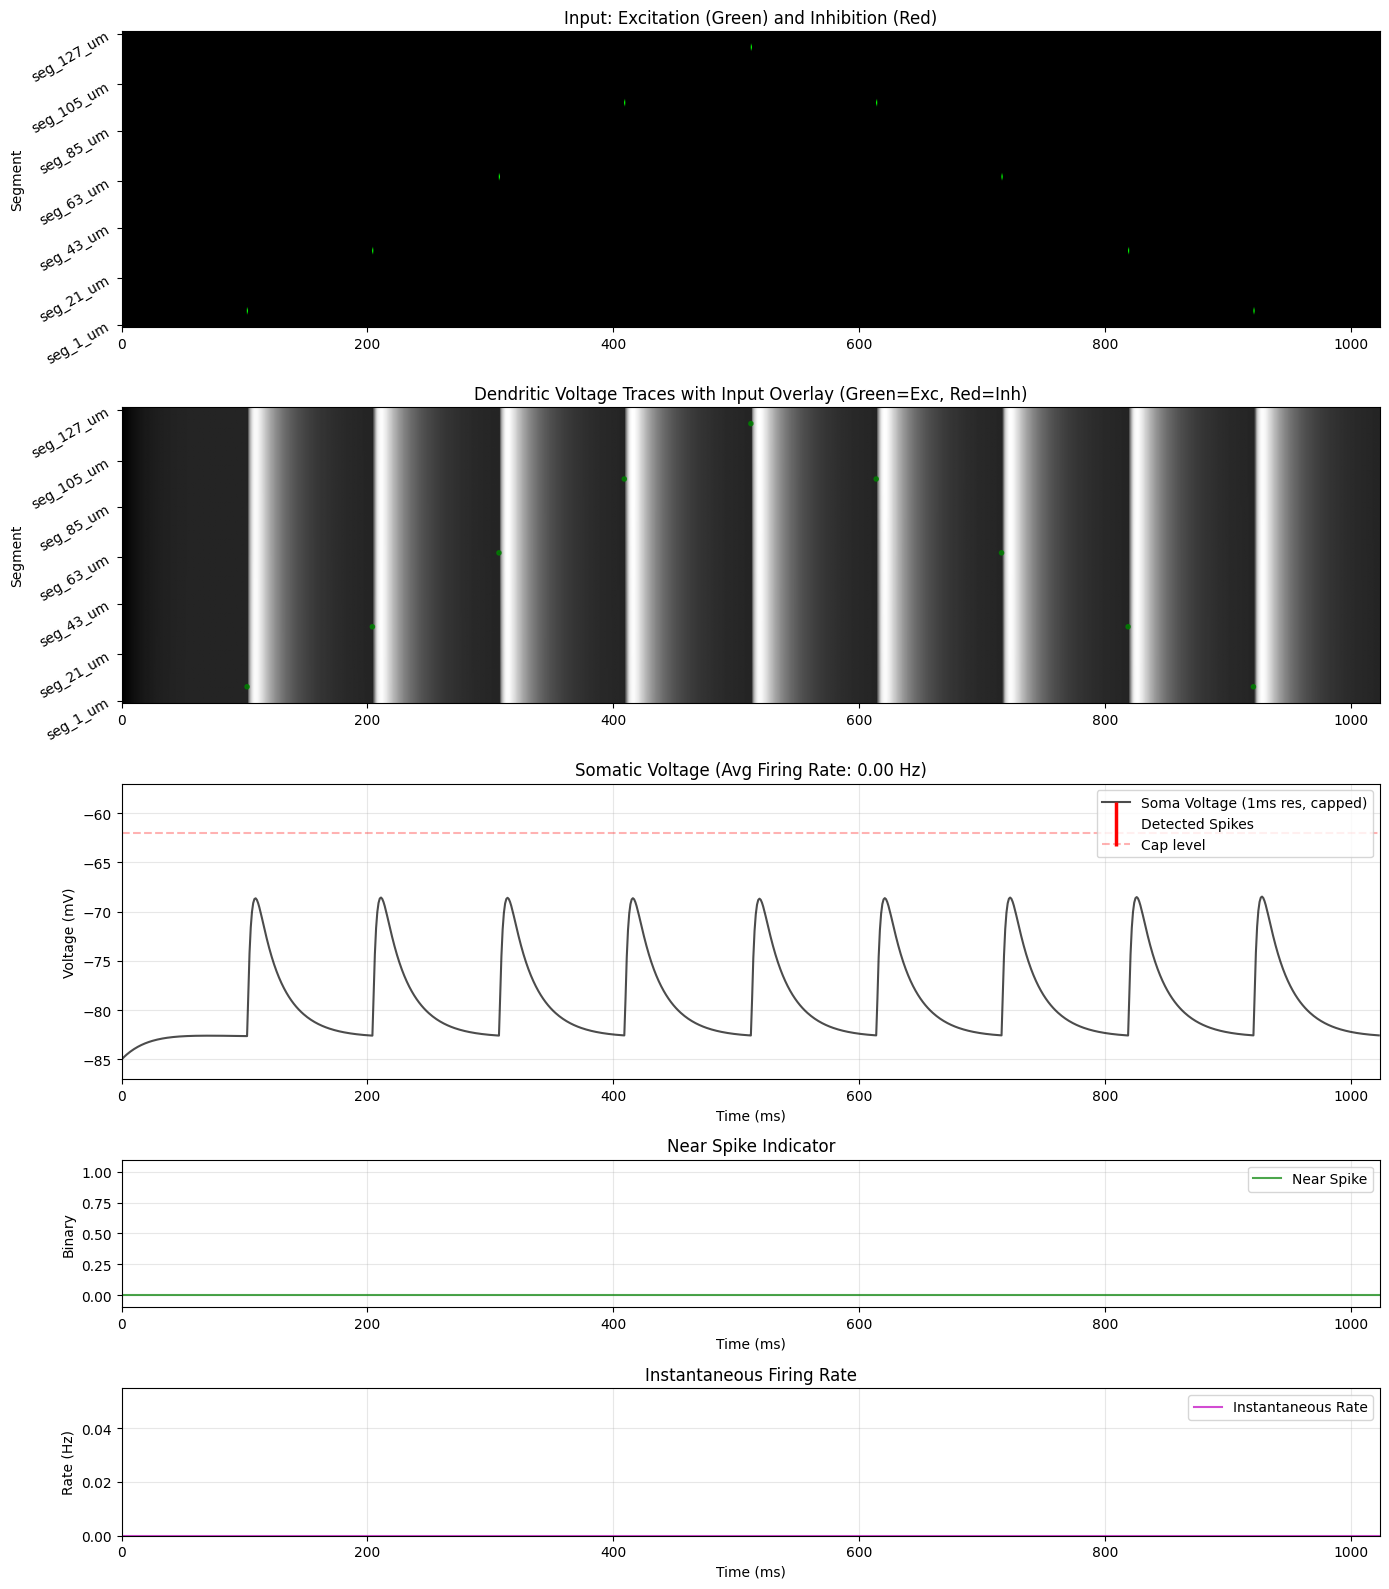

In [78]:
# Plot results
if X_exc_weighted_spikes.max() != 0:
    X_exc_weighted_spikes_normalized = X_exc_weighted_spikes / X_exc_weighted_spikes.max()
else:
    X_exc_weighted_spikes_normalized = X_exc_weighted_spikes

if X_inh_weighted_spikes.max() != 0:
    X_inh_weighted_spikes_normalized = X_inh_weighted_spikes / X_inh_weighted_spikes.max()
else:
    X_inh_weighted_spikes_normalized = X_inh_weighted_spikes

# Create RGB image of input
X_weighted_spikes_as_RGB = np.zeros((ball_and_stick_neuron.num_segments, sim_T_ms, 3))
X_weighted_spikes_as_RGB[:, :, 1] = X_exc_weighted_spikes_normalized  # Green for excitation
X_weighted_spikes_as_RGB[:, :, 0] = X_inh_weighted_spikes_normalized  # Red for inhibition

# Get spike coordinates for overlay
scatter_scale_factor = 1.5
exc_segment_coords, exc_time_coords = np.where(X_exc_weighted_spikes > 0)
exc_magnitudes = scatter_scale_factor * X_exc_weighted_spikes[exc_segment_coords, exc_time_coords]
inh_segment_coords, inh_time_coords = np.where(X_inh_weighted_spikes > 0)
inh_magnitudes = scatter_scale_factor * X_inh_weighted_spikes[inh_segment_coords, inh_time_coords]

# Flip coordinates for display
exc_segment_coords_flipped = (ball_and_stick_neuron.num_segments - 1) - exc_segment_coords
inh_segment_coords_flipped = (ball_and_stick_neuron.num_segments - 1) - inh_segment_coords

# Select evenly-spaced segments for y-axis ticks
num_y_ticks = 7
tick_indices = np.linspace(0, ball_and_stick_neuron.num_segments - 1, num_y_ticks, dtype=int)
tick_labels = [ball_and_stick_neuron.seg_names[i] for i in tick_indices]
tick_positions = [(ball_and_stick_neuron.num_segments - 1 - i) for i in tick_indices]

# Create main figure
plt.figure(figsize=(14, 16))
gs = gridspec.GridSpec(5, 1, height_ratios=[2, 2, 2, 1, 1])
plt.subplots_adjust(hspace=0.4)

# Plot 1: Input spikes
ax1 = plt.subplot(gs[0])
ax1.imshow(np.flipud(X_weighted_spikes_as_RGB), aspect='auto')
ax1.set_ylabel('Segment')
ax1.set_title('Input: Excitation (Green) and Inhibition (Red)')
ax1.set_yticks(tick_positions)
ax1.set_yticklabels(tick_labels, rotation=30)
ax1.set_xlim(0, sim_T_ms)

# Plot 2: Dendritic voltages with input overlay
ax2 = plt.subplot(gs[1])
ax2.imshow(np.flipud(branch_voltages), aspect='auto', cmap='gray')
ax2.scatter(exc_time_coords, exc_segment_coords_flipped, s=exc_magnitudes, c='green', alpha=0.8)
ax2.scatter(inh_time_coords, inh_segment_coords_flipped, s=inh_magnitudes, c='red', alpha=0.5)
ax2.set_ylabel('Segment')
ax2.set_title('Dendritic Voltage Traces with Input Overlay (Green=Exc, Red=Inh)')
ax2.set_yticks(tick_positions)
ax2.set_yticklabels(tick_labels, rotation=30)
ax2.set_xlim(0, sim_T_ms)

# Plot 3: Somatic voltage
ax3 = plt.subplot(gs[2])
spike_times = np.where(y_spike)[0]
ax3.plot(y_soma, 'k', label='Soma Voltage (1ms res, capped)', alpha=0.7)
ax3.scatter(spike_times, [soma_voltage_cap_mV] * len(spike_times), c='red', marker='|', s=1000, 
           label='Detected Spikes', linewidths=2.5, zorder=10)
ax3.axhline(y=soma_voltage_cap_mV, color='r', linestyle='--', alpha=0.3, label='Cap level')
ax3.set_xlabel('Time (ms)')
ax3.set_ylabel('Voltage (mV)')
ax3.set_title(f'Somatic Voltage (Avg Firing Rate: {y_spike.mean() * 1000:.2f} Hz)')
ax3.legend(loc='upper right')
ax3.set_xlim(0, sim_T_ms)
ax3.set_ylim(epas_mV - 2, soma_voltage_cap_mV + 5)
ax3.grid(True, alpha=0.3)

# Plot 4: Near spike indicator
ax4 = plt.subplot(gs[3])
ax4.plot(y_near_spike.astype(float), 'g', alpha=0.7, label='Near Spike')
ax4.scatter(spike_times, [1] * len(spike_times), c='red', marker='|', s=1000, linewidths=2.5)
ax4.set_xlabel('Time (ms)')
ax4.set_ylabel('Binary')
ax4.set_title('Near Spike Indicator')
ax4.legend(loc='upper right')
ax4.set_xlim(0, sim_T_ms)
ax4.set_ylim(-0.1, 1.1)
ax4.grid(True, alpha=0.3)

# Plot 5: Instantaneous firing rate
ax5 = plt.subplot(gs[4])
ax5.plot(1000 * y_inst_rate, 'm', alpha=0.7, label='Instantaneous Rate')
ax5.set_xlabel('Time (ms)')
ax5.set_ylabel('Rate (Hz)')
ax5.set_title('Instantaneous Firing Rate')
ax5.legend(loc='upper right')
ax5.set_xlim(0, sim_T_ms)
ax5.set_ylim(0, None)
ax5.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# What can we see above?

now all dendritic locations created the exact same voltage trace at the soma, and all of the dendritic compartments are now identically depolarized.  
we have essentially created a point neuron.  

# Lets run again with random input as well on the long dendrite and see if we get some spikes

----------------------------------------------
Ball-and-Stick Neuron initialized
Short name: BallAndStickNeuron_Soma_Hay2011_Dend_Lxd_2048um_x_1_0um_64segs
----------------------------------------------
  Morphology:
    Number of segments: 64
    Soma: L=25.0 um, diam=25.0 um
    Dendrite: L=2048.0 um, diam=1.0 um
    Lambda: 577.35 um
    Branch length in units of lambda: 3.55
    Each segment length in units of lambda: 0.0554
  Biophysics:
    Ra: 150.0 ohm*cm
    cm: 1.0 uF/cm^2
    Rm: 20000.0 ohm*cm^2
    epas: -85 mV
  Synapses:
    g_max_AMPA: 0.0004 uS
    g_max_NMDA: 0.0008 uS
    gamma_NMDA: 0.08
    g_max_GABA_A: 0.001 uS
  Active conductances:
    multiplicative_rho_factor: 1.0
    multiplicative_SKE2_factor: 0.0
  Simulation:
    samples per ms: 40
    dt: 0.025 ms (calculated as 1/samples_per_ms)
  Spike detection:
    threshold: 0.0 mV
  Output voltage caps:
    soma_voltage_cap: -62.0 mV
    dend_voltage_cap: 0.0 mV
  Near-spike parameters:
    near_spike_V_diff: 5 mV


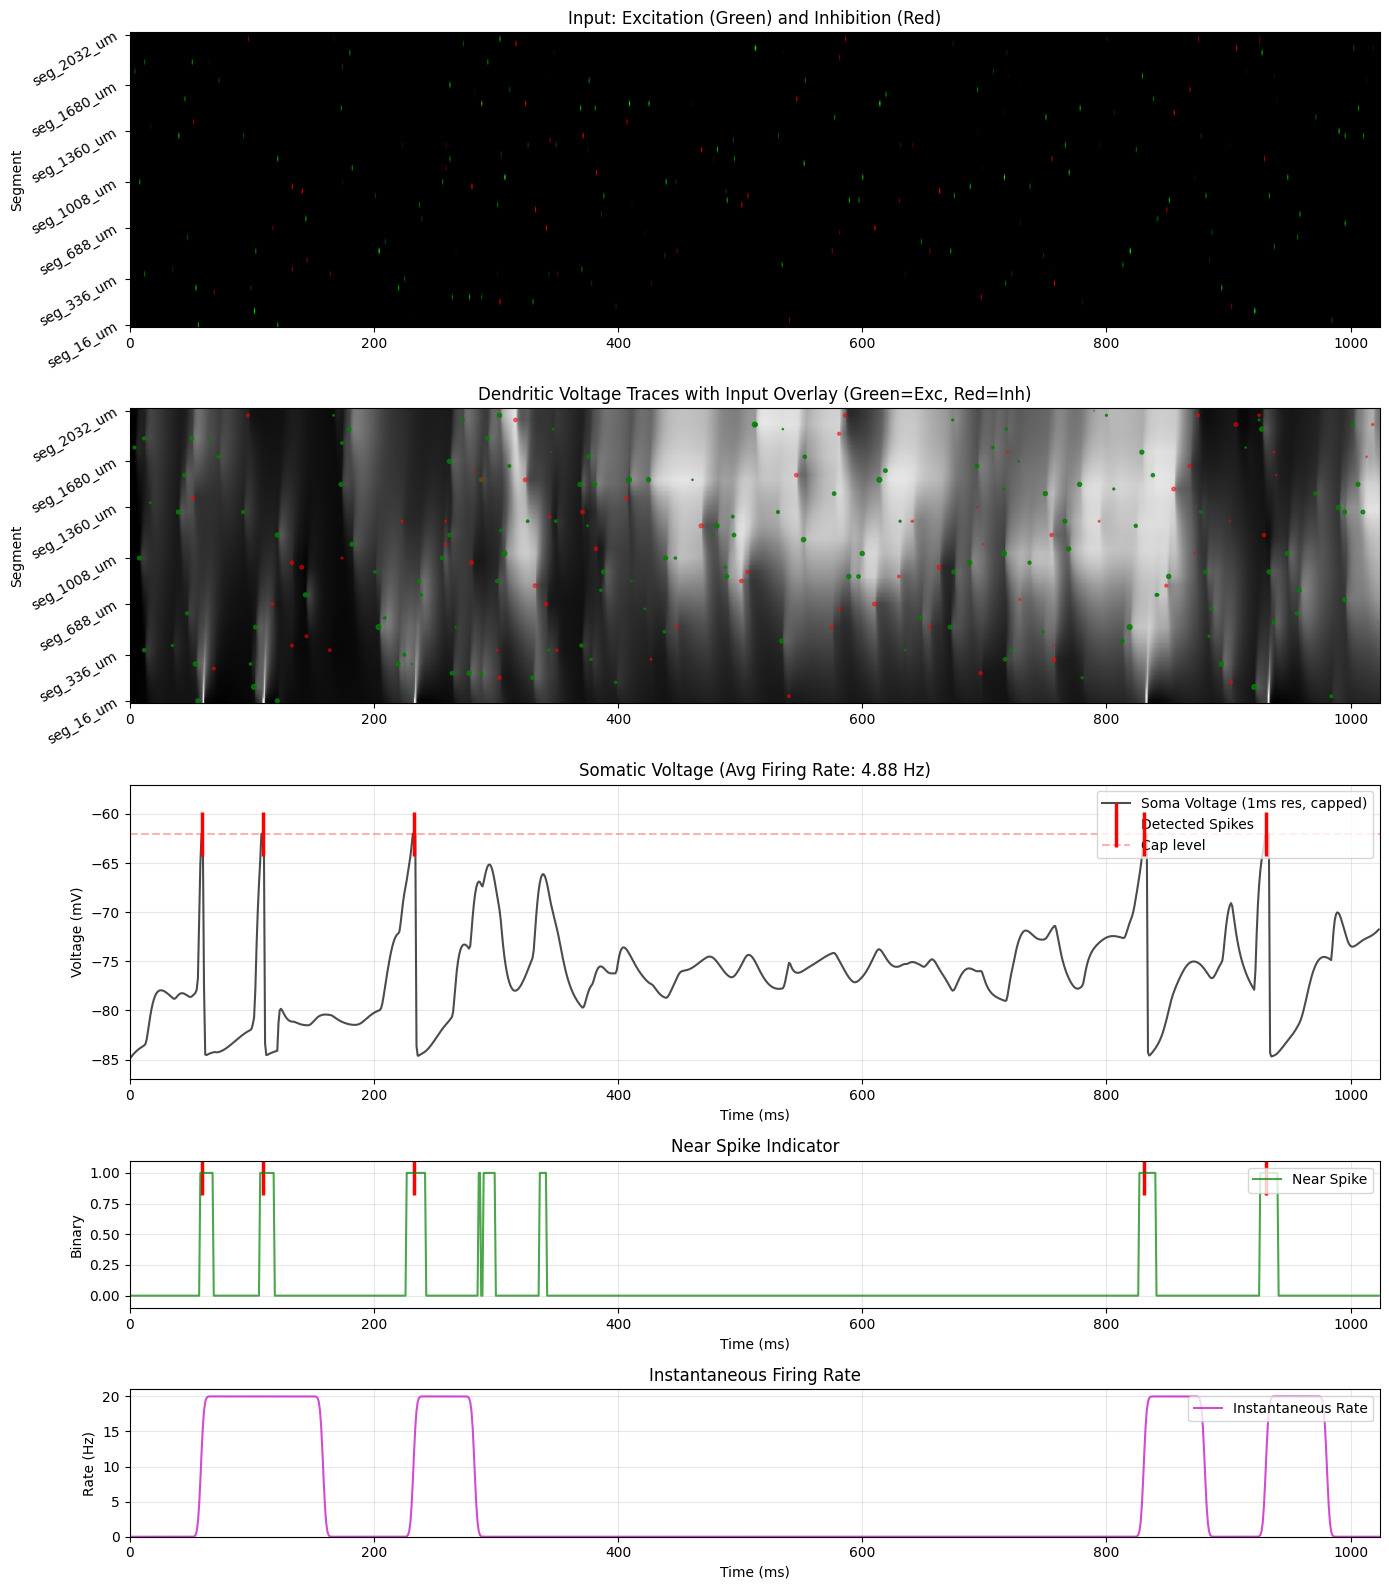

In [79]:
# some high-level parameters
# exc_synapse_type = 'AMPA'
# exc_synapse_type = 'NMDA (rodent)'
exc_synapse_type = 'NMDA (human)' # larger NMDA:AMPA ratio, steeper NMDA voltage dependence 

# SKE2 channel controls a very long hyperpolarizing current after a spike
disable_SKE2_channel = True
# disable_SKE2_channel = False

# Define all parameters
num_segments = 64
soma_L_um = 25.0
soma_diam_um = 25.0

# large dendrite (~3.5 times lambda)
dend_L_um = 2048.0
dend_diam_um = 1.0

# small dendrite (~0.1 times lambda) - basically a point neuron
# dend_L_um = 128.0
# dend_diam_um = 4.0

# passive biophysics
Ra_ohm_cm = 150.0
cm_uF_cm2 = 1.0
Rm_ohm_cm2 = 20000.0
epas_mV = -85

# synapses
if exc_synapse_type == 'AMPA':
    g_max_AMPA_uS = 0.0004
    g_max_NMDA_uS = 0.0000 # no NMDA conductance
    gamma_NMDA = 0.062
elif exc_synapse_type == 'NMDA (rodent)':
    g_max_AMPA_uS = 0.0004
    g_max_NMDA_uS = 0.0004
    gamma_NMDA = 0.062
elif exc_synapse_type == 'NMDA (human)':
    g_max_AMPA_uS = 0.0004
    g_max_NMDA_uS = 0.0008 # larger NMDA:AMPA ratio
    gamma_NMDA = 0.08      # steeper NMDA voltage dependence
g_max_GABA_A_uS = 0.001

# active conductances multipliers
multiplicative_rho_factor = 1.0
if disable_SKE2_channel:
    multiplicative_SKE2_factor = 0.0
else:
    multiplicative_SKE2_factor = 1.0

# simulation parameters
num_samples_per_ms = 40
spike_detection_threshold_mV = 0.0
soma_voltage_cap_mV = -62.0
dend_voltage_cap_mV = 0.0
near_spike_V_diff = 5
near_spike_t_diff = 10
inst_rate_t_diff = 50
inst_rate_smoothing_tau = 2.0

# Create neuron with defined parameters
ball_and_stick_neuron = BallAndStickNeuron(
    num_segments=num_segments,
    soma_L_um=soma_L_um,
    soma_diam_um=soma_diam_um,
    dend_L_um=dend_L_um,
    dend_diam_um=dend_diam_um,
    Ra_ohm_cm=Ra_ohm_cm,
    cm_uF_cm2=cm_uF_cm2,
    Rm_ohm_cm2=Rm_ohm_cm2,
    epas_mV=epas_mV,
    g_max_AMPA_uS=g_max_AMPA_uS,
    g_max_NMDA_uS=g_max_NMDA_uS,
    gamma_NMDA=gamma_NMDA,
    g_max_GABA_A_uS=g_max_GABA_A_uS,
    multiplicative_rho_factor=multiplicative_rho_factor,
    multiplicative_SKE2_factor=multiplicative_SKE2_factor,
    num_samples_per_ms=num_samples_per_ms,
    spike_detection_threshold_mV=spike_detection_threshold_mV,
    soma_voltage_cap_mV=soma_voltage_cap_mV,
    dend_voltage_cap_mV=dend_voltage_cap_mV,
    near_spike_V_diff=near_spike_V_diff,
    near_spike_t_diff=near_spike_t_diff,
    inst_rate_t_diff=inst_rate_t_diff,
    inst_rate_smoothing_tau=inst_rate_smoothing_tau,
)

# Simulation parameters
sim_T_ms = 1024

# Generate random sparse input
exc_max_magnitude_factor = 6
exc_sparsity_level = 0.998
# exc_sparsity_level = 0.99999999
inh_max_magnitude_factor = 5
inh_sparsity_level = 0.999
# inh_sparsity_level = 0.99999999

X_exc_weighted_spikes = np.random.rand(ball_and_stick_neuron.num_segments, sim_T_ms) * exc_max_magnitude_factor
X_exc_weighted_spikes[np.random.rand(ball_and_stick_neuron.num_segments, sim_T_ms) < exc_sparsity_level] = 0.0

X_inh_weighted_spikes = np.random.rand(ball_and_stick_neuron.num_segments, sim_T_ms) * inh_max_magnitude_factor
X_inh_weighted_spikes[np.random.rand(ball_and_stick_neuron.num_segments, sim_T_ms) < inh_sparsity_level] = 0.0

# Add patterned excitatory spikes from proximal to distal and back
patterned_magnitude = 8.0
X_exc_weighted_spikes[int(0.05 * ball_and_stick_neuron.num_segments), int(0.1 * sim_T_ms)] = patterned_magnitude
X_exc_weighted_spikes[int(0.25 * ball_and_stick_neuron.num_segments), int(0.2 * sim_T_ms)] = patterned_magnitude
X_exc_weighted_spikes[int(0.50 * ball_and_stick_neuron.num_segments), int(0.3 * sim_T_ms)] = patterned_magnitude
X_exc_weighted_spikes[int(0.75 * ball_and_stick_neuron.num_segments), int(0.4 * sim_T_ms)] = patterned_magnitude
X_exc_weighted_spikes[int(0.95 * ball_and_stick_neuron.num_segments), int(0.5 * sim_T_ms)] = patterned_magnitude
X_exc_weighted_spikes[int(0.75 * ball_and_stick_neuron.num_segments), int(0.6 * sim_T_ms)] = patterned_magnitude
X_exc_weighted_spikes[int(0.50 * ball_and_stick_neuron.num_segments), int(0.7 * sim_T_ms)] = patterned_magnitude
X_exc_weighted_spikes[int(0.25 * ball_and_stick_neuron.num_segments), int(0.8 * sim_T_ms)] = patterned_magnitude
X_exc_weighted_spikes[int(0.05 * ball_and_stick_neuron.num_segments), int(0.9 * sim_T_ms)] = patterned_magnitude

# Run simulation
print('----------------------------------------------')
print('Running simulation...')
simulation_output = ball_and_stick_neuron.simulate(X_exc_weighted_spikes, X_inh_weighted_spikes, return_hr_soma=True)
print('Simulation complete!')
print('----------------------------------------------')

# Extract outputs
branch_voltages = simulation_output['branch_voltages']
y_soma = simulation_output['y_soma']
y_spike = simulation_output['y_spike']
y_near_spike = simulation_output['y_near_spike']
y_inst_rate = simulation_output['y_inst_rate']
y_soma_HR = simulation_output['y_soma_HR']

# Print output statistics
print('Output shapes:')
print(f'  branch_voltages: {branch_voltages.shape}')
print(f'  y_soma: {y_soma.shape}')
print(f'  y_spike: {y_spike.shape}')
print(f'  y_near_spike: {y_near_spike.shape}')
print(f'  y_inst_rate: {y_inst_rate.shape}')
print(f'  y_soma_HR: {y_soma_HR.shape}')
print('----------------------------------------------')
print(f'Number of spikes: {y_spike.sum()}')
print(f'Average firing rate: {y_spike.mean() * 1000:.2f} Hz')
print('----------------------------------------------')

# Plot results
if X_exc_weighted_spikes.max() != 0:
    X_exc_weighted_spikes_normalized = X_exc_weighted_spikes / X_exc_weighted_spikes.max()
else:
    X_exc_weighted_spikes_normalized = X_exc_weighted_spikes

if X_inh_weighted_spikes.max() != 0:
    X_inh_weighted_spikes_normalized = X_inh_weighted_spikes / X_inh_weighted_spikes.max()
else:
    X_inh_weighted_spikes_normalized = X_inh_weighted_spikes

# Create RGB image of input
X_weighted_spikes_as_RGB = np.zeros((ball_and_stick_neuron.num_segments, sim_T_ms, 3))
X_weighted_spikes_as_RGB[:, :, 1] = X_exc_weighted_spikes_normalized  # Green for excitation
X_weighted_spikes_as_RGB[:, :, 0] = X_inh_weighted_spikes_normalized  # Red for inhibition

# Get spike coordinates for overlay
scatter_scale_factor = 1.5
exc_segment_coords, exc_time_coords = np.where(X_exc_weighted_spikes > 0)
exc_magnitudes = scatter_scale_factor * X_exc_weighted_spikes[exc_segment_coords, exc_time_coords]
inh_segment_coords, inh_time_coords = np.where(X_inh_weighted_spikes > 0)
inh_magnitudes = scatter_scale_factor * X_inh_weighted_spikes[inh_segment_coords, inh_time_coords]

# Flip coordinates for display
exc_segment_coords_flipped = (ball_and_stick_neuron.num_segments - 1) - exc_segment_coords
inh_segment_coords_flipped = (ball_and_stick_neuron.num_segments - 1) - inh_segment_coords

# Select evenly-spaced segments for y-axis ticks
num_y_ticks = 7
tick_indices = np.linspace(0, ball_and_stick_neuron.num_segments - 1, num_y_ticks, dtype=int)
tick_labels = [ball_and_stick_neuron.seg_names[i] for i in tick_indices]
tick_positions = [(ball_and_stick_neuron.num_segments - 1 - i) for i in tick_indices]

# Create main figure
plt.figure(figsize=(14, 16))
gs = gridspec.GridSpec(5, 1, height_ratios=[2, 2, 2, 1, 1])
plt.subplots_adjust(hspace=0.4)

# Plot 1: Input spikes
ax1 = plt.subplot(gs[0])
ax1.imshow(np.flipud(X_weighted_spikes_as_RGB), aspect='auto')
ax1.set_ylabel('Segment')
ax1.set_title('Input: Excitation (Green) and Inhibition (Red)')
ax1.set_yticks(tick_positions)
ax1.set_yticklabels(tick_labels, rotation=30)
ax1.set_xlim(0, sim_T_ms)

# Plot 2: Dendritic voltages with input overlay
ax2 = plt.subplot(gs[1])
ax2.imshow(np.flipud(branch_voltages), aspect='auto', cmap='gray')
ax2.scatter(exc_time_coords, exc_segment_coords_flipped, s=exc_magnitudes, c='green', alpha=0.8)
ax2.scatter(inh_time_coords, inh_segment_coords_flipped, s=inh_magnitudes, c='red', alpha=0.5)
ax2.set_ylabel('Segment')
ax2.set_title('Dendritic Voltage Traces with Input Overlay (Green=Exc, Red=Inh)')
ax2.set_yticks(tick_positions)
ax2.set_yticklabels(tick_labels, rotation=30)
ax2.set_xlim(0, sim_T_ms)

# Plot 3: Somatic voltage
ax3 = plt.subplot(gs[2])
spike_times = np.where(y_spike)[0]
ax3.plot(y_soma, 'k', label='Soma Voltage (1ms res, capped)', alpha=0.7)
ax3.scatter(spike_times, [soma_voltage_cap_mV] * len(spike_times), c='red', marker='|', s=1000, 
           label='Detected Spikes', linewidths=2.5, zorder=10)
ax3.axhline(y=soma_voltage_cap_mV, color='r', linestyle='--', alpha=0.3, label='Cap level')
ax3.set_xlabel('Time (ms)')
ax3.set_ylabel('Voltage (mV)')
ax3.set_title(f'Somatic Voltage (Avg Firing Rate: {y_spike.mean() * 1000:.2f} Hz)')
ax3.legend(loc='upper right')
ax3.set_xlim(0, sim_T_ms)
ax3.set_ylim(epas_mV - 2, soma_voltage_cap_mV + 5)
ax3.grid(True, alpha=0.3)

# Plot 4: Near spike indicator
ax4 = plt.subplot(gs[3])
ax4.plot(y_near_spike.astype(float), 'g', alpha=0.7, label='Near Spike')
ax4.scatter(spike_times, [1] * len(spike_times), c='red', marker='|', s=1000, linewidths=2.5)
ax4.set_xlabel('Time (ms)')
ax4.set_ylabel('Binary')
ax4.set_title('Near Spike Indicator')
ax4.legend(loc='upper right')
ax4.set_xlim(0, sim_T_ms)
ax4.set_ylim(-0.1, 1.1)
ax4.grid(True, alpha=0.3)

# Plot 5: Instantaneous firing rate
ax5 = plt.subplot(gs[4])
ax5.plot(1000 * y_inst_rate, 'm', alpha=0.7, label='Instantaneous Rate')
ax5.set_xlabel('Time (ms)')
ax5.set_ylabel('Rate (Hz)')
ax5.set_title('Instantaneous Firing Rate')
ax5.legend(loc='upper right')
ax5.set_xlim(0, sim_T_ms)
ax5.set_ylim(0, None)
ax5.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Lets also inspect the High-Resolution Soma Voltage

This plot shows the uncapped, high-resolution soma voltage trace. This view is useful for:

- Seeing the full dynamics of action potentials
- Verifying spike detection accuracy

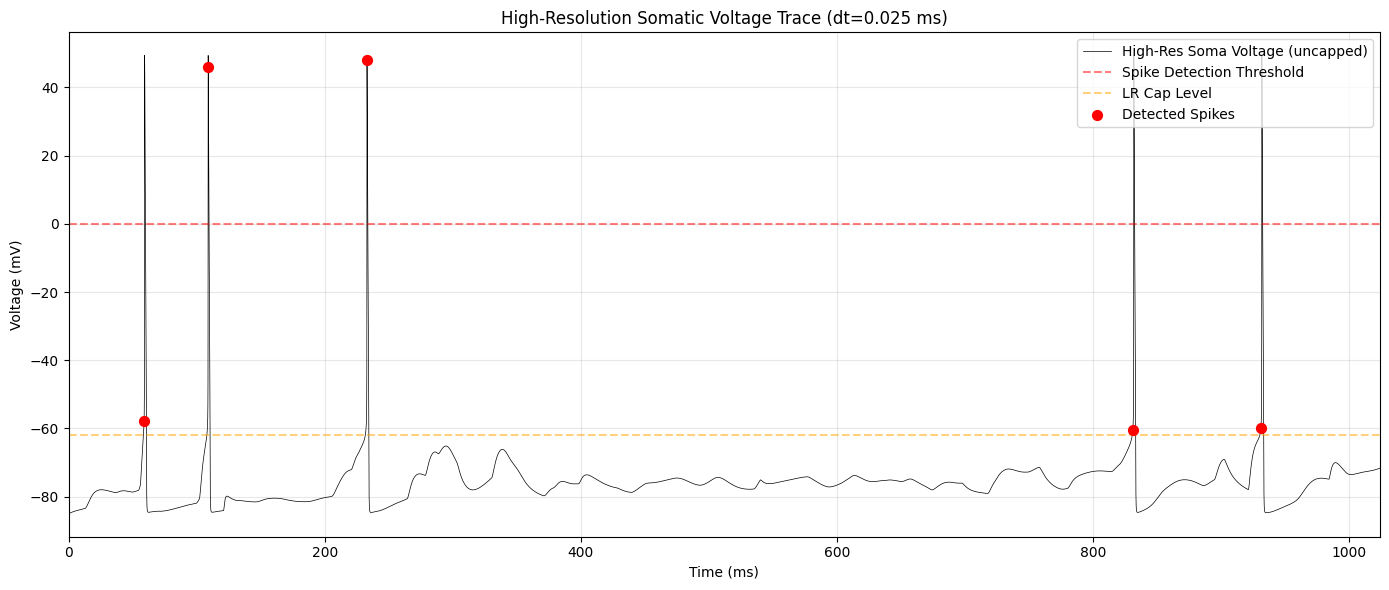

In [80]:
# Plot high-resolution soma voltage (separate figure)
t_HR = np.arange(len(y_soma_HR)) * ball_and_stick_neuron.dt_ms

plt.figure(figsize=(14, 6))
plt.plot(t_HR, y_soma_HR, 'k', linewidth=0.5, label='High-Res Soma Voltage (uncapped)')
plt.axhline(y=spike_detection_threshold_mV, color='r', linestyle='--', alpha=0.5, label='Spike Detection Threshold')
plt.axhline(y=soma_voltage_cap_mV, color='orange', linestyle='--', alpha=0.5, label='LR Cap Level')

# Mark detected spike peaks
spike_peak_indices = np.where(y_spike)[0] * ball_and_stick_neuron.num_samples_per_ms
if len(spike_peak_indices) > 0:
    plt.scatter(t_HR[spike_peak_indices], y_soma_HR[spike_peak_indices], c='red', s=50, zorder=10, label='Detected Spikes')

plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.title(f'High-Resolution Somatic Voltage Trace (dt={ball_and_stick_neuron.dt_ms:.3f} ms)')
plt.legend(loc='upper right')
plt.xlim(0, sim_T_ms)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Save and Load Model Parameters

The model supports saving all its configuration parameters to a pickle file and loading them later. This is useful for:

- Reproducing results with the exact same model configuration
- Sharing model parameters with collaborators
- Keeping a record of model versions used in different experiments

Note: This saves only the parameters, not the NEURON state or simulation results.


In [81]:
# Test save/load functionality
save_and_load = True
# save_and_load = False

if save_and_load:
    print('----------------------------------------------')
    print('Testing save/load functionality...')
    # Save to saved_models folder in the project root (we changed to project root at the start)
    save_folder = 'saved_models'
    saved_path = ball_and_stick_neuron.save(save_folder)
    
    # Load the model
    loaded_ball_and_stick_neuron = BallAndStickNeuron.load(saved_path)
    print('Model loaded successfully!')
    print('----------------------------------------------')


----------------------------------------------
Testing save/load functionality...
Model saved to: saved_models/ball_and_stick_neuron_BallAndStickNeuron_Soma_Hay2011_Dend_Lxd_2048um_x_1_0um_64segs__2025_11_02_04h05m.pkl
----------------------------------------------
Ball-and-Stick Neuron initialized
Short name: BallAndStickNeuron_Soma_Hay2011_Dend_Lxd_2048um_x_1_0um_64segs
----------------------------------------------
  Morphology:
    Number of segments: 64
    Soma: L=25.0 um, diam=25.0 um
    Dendrite: L=2048.0 um, diam=1.0 um
    Lambda: 577.35 um
    Branch length in units of lambda: 3.55
    Each segment length in units of lambda: 0.0554
  Biophysics:
    Ra: 150.0 ohm*cm
    cm: 1.0 uF/cm^2
    Rm: 20000.0 ohm*cm^2
    epas: -85 mV
  Synapses:
    g_max_AMPA: 0.0004 uS
    g_max_NMDA: 0.0008 uS
    gamma_NMDA: 0.08
    g_max_GABA_A: 0.001 uS
  Active conductances:
    multiplicative_rho_factor: 1.0
    multiplicative_SKE2_factor: 0.0
  Simulation:
    samples per ms: 40
    dt: 